In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from matplotlib import rcParams

from statsmodels.graphics import tsaplots
import statsmodels.api as sm

In [63]:
data = pd.read_csv('ECONOMICS_USCSHPIMM, 1M.csv')

In [4]:
data.head()

,time,close
0,949363200,0.8
1,951868800,1.2
2,954547200,1.5
3,957139200,1.6
4,959817600,1.5


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    294 non-null    int64  
 1   close   294 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.7 KB


In [6]:
data.columns

Index(['time', 'close'], dtype='object')

In [64]:
data = data.drop('time',axis=1)

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   294 non-null    float64
dtypes: float64(1)
memory usage: 2.4 KB


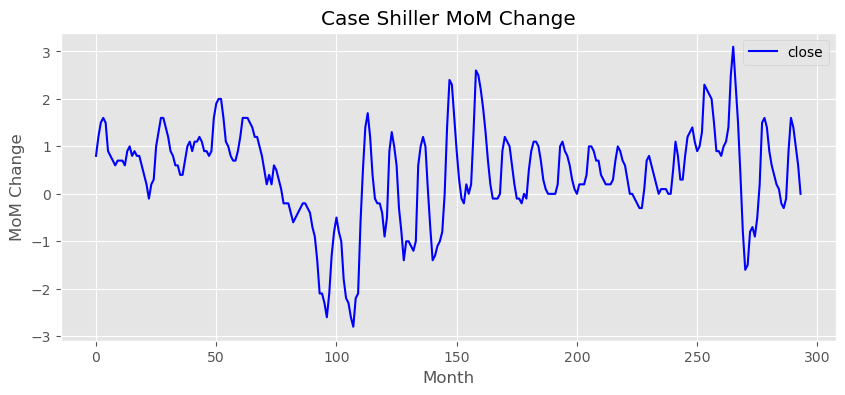

In [66]:
data.plot(figsize=(10, 4),color='blue')
plt.xlabel("Month")
plt.ylabel('MoM Change')
plt.title("Case Shiller MoM Change")
plt.show()

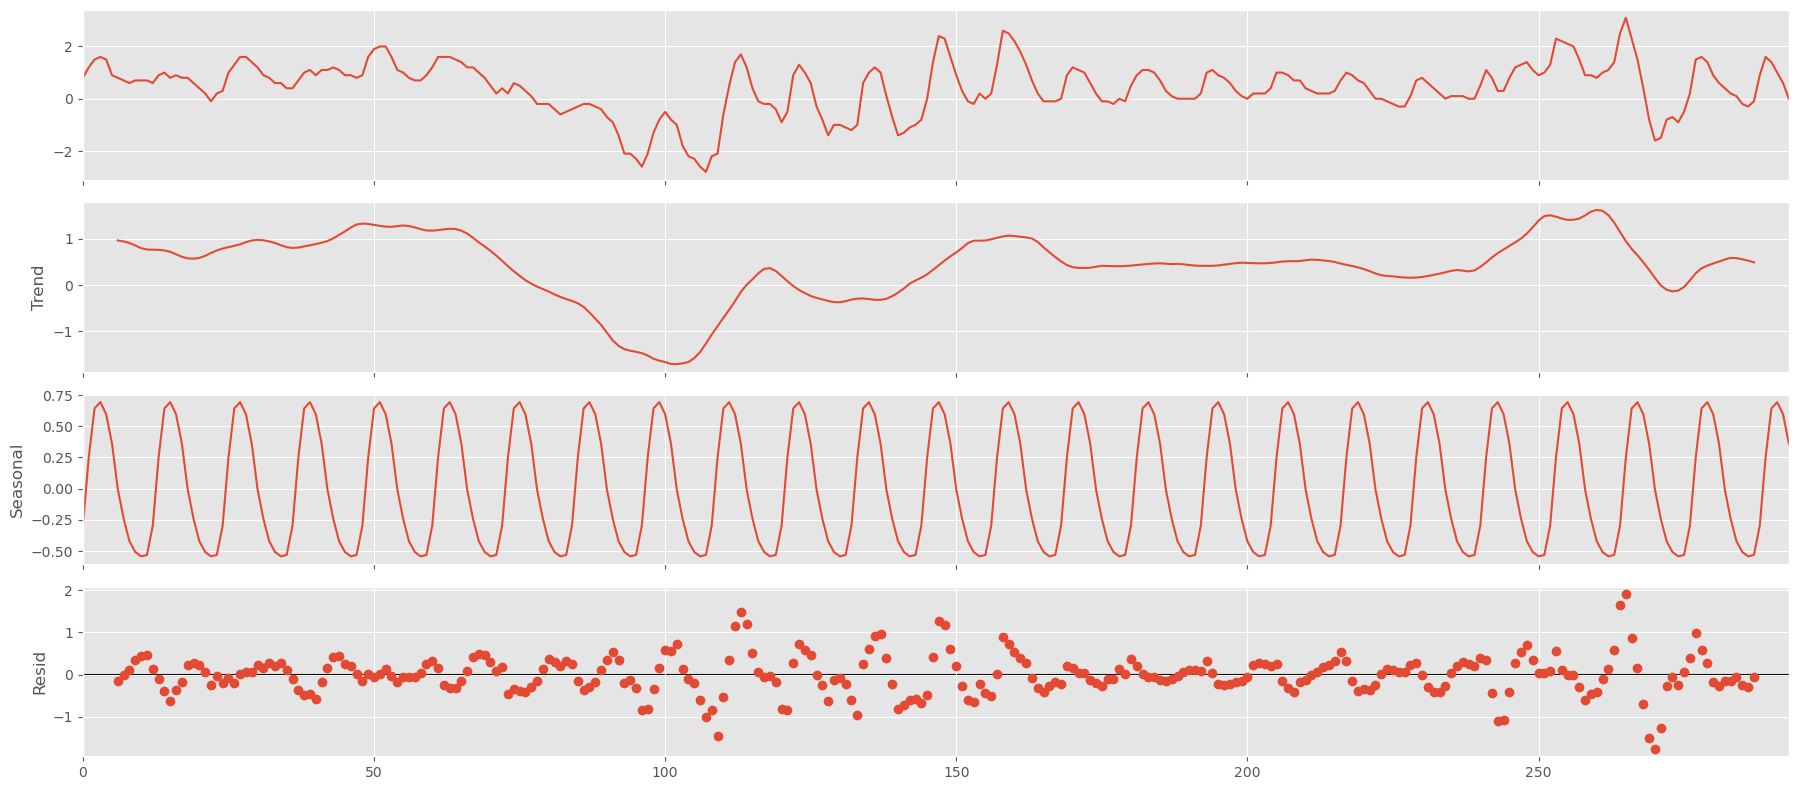

In [10]:
#Furniture sales time-series decomposition
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive', period = 12)
fig = decomposition.plot()
plt.show()

In [11]:
data_raw = data.to_numpy()

In [12]:
# Normalize data to zero mean and unit variance
# scaler = StandardScalar()
# scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer()


data_scaled = scaler.fit_transform(data_raw)
# print(data_scaled)

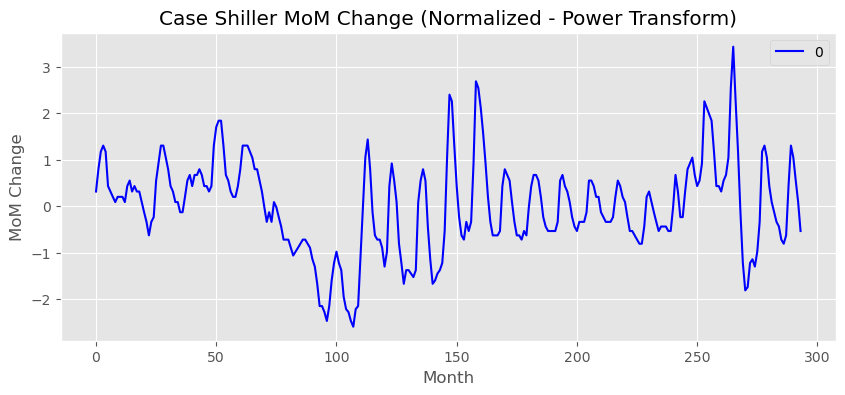

In [13]:
pd.DataFrame(data_scaled).plot(figsize=(10, 4),color='blue')
plt.xlabel("Month")
plt.ylabel('MoM Change')
plt.title("Case Shiller MoM Change (Normalized - Power Transform)")
plt.show()

In [14]:
data_scaled.shape

(294, 1)

In [29]:
# Split data using 70/30 train/test split
split = round(len(data)*.7)
number_targets = len(data) - split

train_data = data_scaled[:split]
test_data = data_scaled[split:]
print(train_data.shape)
print(test_data.shape)

(206, 1)
(88, 1)


In [30]:
# Parameters
n_input = number_targets
n_features = 1
batch_size = 10
epochs = 150

# Convert training data into sequences (sliding windows) needed for LSTM. each sequence of 12 the target is the next value, i.e. 13th.
def create_sequences(data, n_input):
    sequences = []
    for i in range(len(data) - n_input):
        seq = data[i:i + n_input]
        label = data[i + n_input]
        sequences.append((seq, label))
    return sequences

train_sequences = create_sequences(train_data, n_input)

# Convert to PyTorch tensors
train_x = torch.tensor([seq[0] for seq in train_sequences], dtype=torch.float32)
train_y = torch.tensor([seq[1] for seq in train_sequences], dtype=torch.float32)

## Create the model and train it - Vanilla LSTM

In [17]:
print(train_x.shape)
print(train_y.shape)

torch.Size([118, 88, 1])
torch.Size([118, 1])


In [18]:
# Dataset and DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with a probability of 0.2
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        x = torch.relu(self.fc1(lstm_out[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [19]:
# Train the model
def train_model(model, train_loader, epochs):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 25 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [20]:
# Make future predictions - run just once
# Initialize and train the model
model = LSTMModel(n_input, n_features)
train_model(model, train_loader, epochs)

model.eval()
pred_list = []
batch = train_data[-n_input:].reshape((1, n_input, n_features))
batch = torch.tensor(batch, dtype=torch.float32)

with torch.no_grad():
    for i in range(n_input):
        pred = model(batch).item()
        pred_list.append(pred)
        batch = torch.cat((batch[:, 1:, :], torch.tensor([[[pred]]], dtype=torch.float32)), dim=1)

# Inverse transform the predictions
predicted_sales = scaler.inverse_transform(np.array(pred_list).reshape(-1, 1))

# Create a dataframe for predictions
df_predict = pd.DataFrame(predicted_sales, index=data[-n_input:].index, columns=['Prediction'])

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [25/150], Loss: 0.0329
Epoch [50/150], Loss: 0.0463
Epoch [75/150], Loss: 0.0361
Epoch [100/150], Loss: 0.0285
Epoch [125/150], Loss: 0.0466
Epoch [150/150], Loss: 0.0120


In [21]:
print(df_predict.shape)
print(df_predict)

(88, 1)
     Prediction
206    1.184566
207    1.151354
208    1.029255
209    0.822540
210    0.503483
..          ...
289    1.003293
290    1.185627
291    1.135397
292    1.004101
293    0.775586

[88 rows x 1 columns]


In [22]:
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [23]:
# Averaging over multiple runs (to keep the loop structure like in the original code)
n_runs = 3
store = np.zeros((n_input, n_runs))
model = LSTMModel(n_input, n_features)

for i in range(n_runs):
    #reset_weights(model)  # Reset the weights to random
    model = LSTMModel(n_input, n_features)
    train_model(model, train_loader, epochs)
    pred_list = []

    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32)

    with torch.no_grad():
        for j in range(n_input):
            pred = model(batch).item()
            pred_list.append(pred)
            batch = torch.cat((batch[:, 1:, :], torch.tensor([[[pred]]], dtype=torch.float32)), dim=1)

    store[:, i] = scaler.inverse_transform(np.array(pred_list).reshape(-1, 1)).flatten()

# Averaging predictions
final_vanilla = np.mean(store, axis=1)

Epoch [25/150], Loss: 0.0453
Epoch [50/150], Loss: 0.0376
Epoch [75/150], Loss: 0.0365
Epoch [100/150], Loss: 0.0408
Epoch [125/150], Loss: 0.0316
Epoch [150/150], Loss: 0.0174
Epoch [25/150], Loss: 0.0578
Epoch [50/150], Loss: 0.0685
Epoch [75/150], Loss: 0.0553
Epoch [100/150], Loss: 0.0393
Epoch [125/150], Loss: 0.0240
Epoch [150/150], Loss: 0.0286
Epoch [25/150], Loss: 0.0462
Epoch [50/150], Loss: 0.0497
Epoch [75/150], Loss: 0.0276
Epoch [100/150], Loss: 0.0422
Epoch [125/150], Loss: 0.0419
Epoch [150/150], Loss: 0.0188


In [24]:
print(final_vanilla.shape)
print(final_vanilla)

(88,)
[ 1.04225855e+00  9.34771513e-01  7.87032483e-01  6.52496261e-01
  3.86577252e-01  1.69930349e-01  5.25591543e-02 -9.45971169e-05
 -1.59913460e-02  1.32626563e-01  3.94671435e-01  7.55240120e-01
  9.54407579e-01  9.45541937e-01  7.53915000e-01  4.50564109e-01
  1.42295064e-01 -3.27546725e-02 -2.19819873e-01 -3.06614152e-01
 -3.01133057e-01 -1.85321157e-01  1.56614180e-01  5.15216985e-01
  8.28073202e-01  6.93849716e-01  3.55172559e-01 -5.11630766e-02
 -4.59473029e-01 -5.81777606e-01 -7.48775897e-01 -8.00681079e-01
 -8.81981639e-01 -5.30682041e-01 -6.75110224e-02  2.59407995e-01
  5.72009275e-01  5.40256751e-01  3.23739855e-01 -1.24275989e-02
 -2.70484745e-01 -6.48771381e-01 -7.68703319e-01 -9.91307666e-01
 -8.04245823e-01 -2.57275018e-01  3.09538450e-01  5.72558025e-01
  7.91967717e-01  8.28310244e-01  4.13144784e-01  7.99376034e-02
 -1.92733762e-01 -5.76437946e-01 -7.96078524e-01 -9.60669494e-01
 -5.92554492e-01  8.40906623e-02  6.02926275e-01  5.83610276e-01
  7.03331606e-01  8

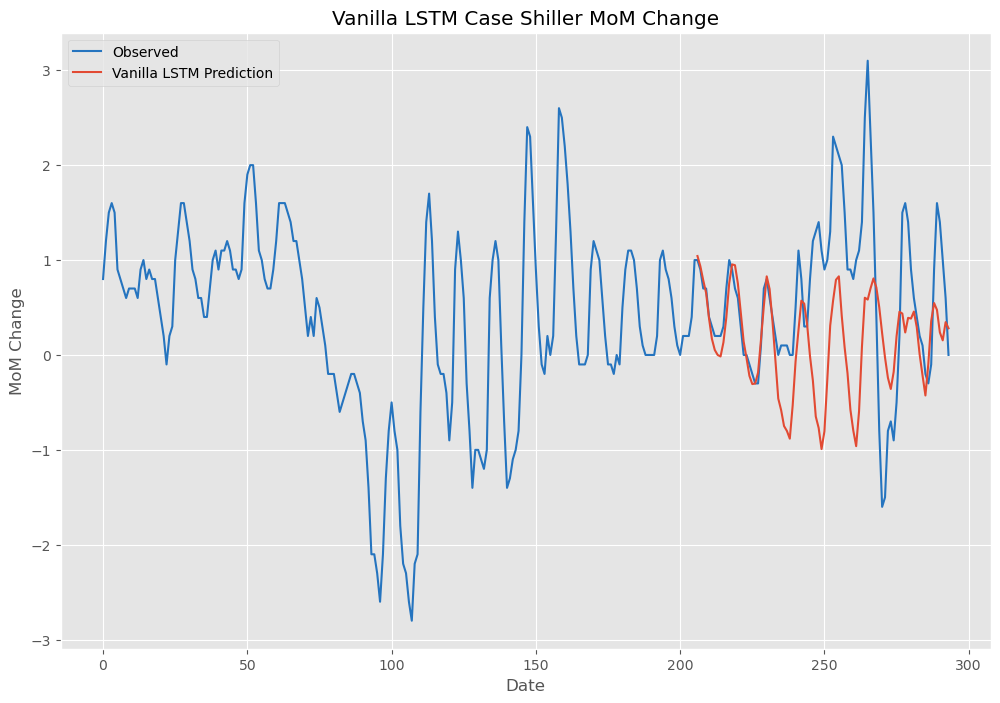

In [68]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(data.index,data,label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_vanilla,label="Vanilla LSTM Prediction")
plt.title('Vanilla LSTM Case Shiller MoM Change')
plt.xlabel('Date')
plt.ylabel('MoM Change')
plt.legend()
plt.show()

In [49]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

In [67]:
data_targets = data.to_numpy()[split:]
vanilla_lstm = performance(data_targets,final_vanilla)
vanilla_lstm


/var/folders/tf/xgr43d3x3gv_27t5cflz7xz00000gp/T/ipykernel_4020/2843865680.py:3: RuntimeWarning: divide by zero encountered in divide
  mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100


{'MSE': 1.19, 'RMSE': 1.09, 'MAPE': inf}

## Stacked LSTM


In [52]:
# Define the stacked LSTM model
class StackedLSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(StackedLSTMModel, self).__init__()
        # First LSTM layer (returns entire sequences)
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True, dropout =0.2,num_layers=2)
        # Second LSTM layer (returns entire sequences)
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=50, batch_first=True)
        #manual dropout
        self.dropout = nn.Dropout(0.2)
        # Fully connected layers
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        lstm_out1, _ = self.lstm1(x)
        lstm_out2, _ = self.lstm2(lstm_out1)
        x = lstm_out2[:, -1, :]  # Get the last time step output
        #x = self.dropout(x)  # Apply dropout here
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [71]:
# Train and predict multiple times
n_runs = 3
store2 = np.zeros((number_targets, n_runs))

for i in range(n_runs):
    # Initialize the model
    model_stacked = StackedLSTMModel(n_input=n_input, n_features=n_features)
    
    # Train the model
    train_model(model_stacked, train_loader, epochs=100)
    
    # Make predictions
    pred_list_s = []
    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32)

    with torch.no_grad():
        for j in range(n_input):
            pred = model_stacked(batch).item()  # Get prediction
            pred_list_s.append(pred)
            # Update the batch by appending the predicted value
            batch = torch.cat((batch[:, 1:, :], torch.tensor([[[pred]]], dtype=torch.float32)), dim=1)

    # Inverse transform the predictions and store them
    store2[:, i] = scaler.inverse_transform(np.array(pred_list_s).reshape(-1, 1)).flatten()

# Average the results across runs (if needed)
final_stacked = np.mean(store2, axis=1)
print(final_stacked)

Epoch [25/100], Loss: 0.0893
Epoch [50/100], Loss: 0.0670
Epoch [75/100], Loss: 0.0464
Epoch [100/100], Loss: 0.0289
Epoch [25/100], Loss: 0.0435
Epoch [50/100], Loss: 0.0498
Epoch [75/100], Loss: 0.0380
Epoch [100/100], Loss: 0.0201
Epoch [25/100], Loss: 0.2052
Epoch [50/100], Loss: 0.0576
Epoch [75/100], Loss: 0.0778
Epoch [100/100], Loss: 0.0227
[ 1.07570743  1.01859492  0.92530062  0.71072707  0.49829749  0.26029085
  0.14233876  0.06438166  0.06169566  0.08579158  0.20925821  0.53107127
  0.81834538  0.94022477  0.91965154  0.76651862  0.57873323  0.40445971
  0.24896631  0.13606299  0.08248045  0.07984939  0.11756426  0.32771093
  0.64167301  0.78686642  0.87051511  0.88070398  0.75029601  0.63362709
  0.4175406   0.26832877  0.14358829  0.11214079  0.08892721  0.15080483
  0.3984599   0.64535991  0.72817465  0.70019539  0.67718039  0.55684098
  0.40699431  0.25694398  0.19062872  0.11819428  0.07054844  0.08911524
  0.2331607   0.41630137  0.56457134  0.57081687  0.4857926   0.3

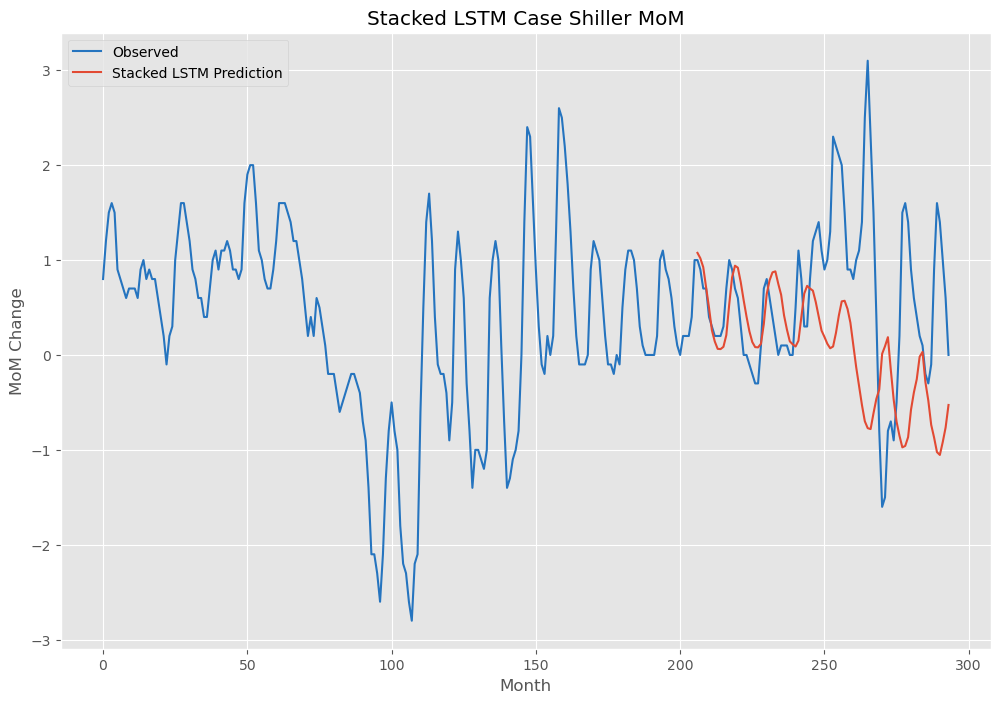

In [73]:
plt.plot(data.index,data,label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_stacked,label="Stacked LSTM Prediction")
plt.title('Stacked LSTM Case Shiller MoM')
plt.xlabel('Month')
plt.ylabel('MoM Change')
plt.legend()
plt.show()

In [74]:
stacked_lstm= performance(data_targets[split:],final_stacked)
stacked_lstm

/var/folders/tf/xgr43d3x3gv_27t5cflz7xz00000gp/T/ipykernel_4020/2843865680.py:2: RuntimeWarning: Mean of empty slice.
  mse = ((y_pred - y_true) ** 2).mean()
/opt/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


{'MSE': nan, 'RMSE': nan, 'MAPE': nan}